<a href="https://colab.research.google.com/github/XueyanZhang/MachineLearningCompilation/blob/master/5_End2End_Auto_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to End Module Automatic Optimization

Put everything we learned so far together.
optimize the performance of the MLP example.

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

import numpy as np
import torch
import torchvision
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 MB 13.7 MB/s eta 0:00:00


In [2]:
test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

100%|██████████| 26421880/26421880 [00:01<00:00, 18714816.77it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 334644.07it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6189069.98it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23217502.14it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



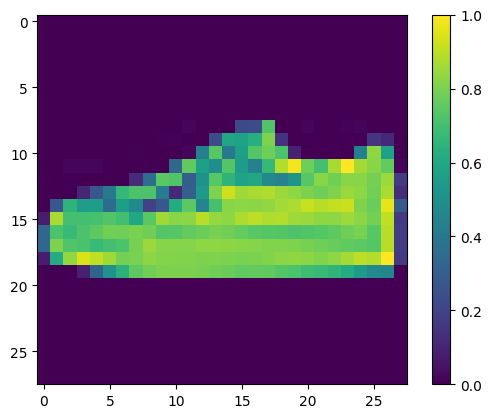

class is Sneaker


In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print(f"class is {class_names[label[0]]}")

In [4]:
# download pre-packed (trained) parameters
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2023-05-06 18:43:29--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2023-05-06 18:43:29--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.007s  

2023-05-06 18:43:29 (56.3 MB/s) - ‘fasionmnist_mlp_params.p

In [5]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

# image input to network
data_nd = tvm.nd.array(img.reshape(1, 784))

In [8]:
from tvm.script.ir_builder.relax.ir import dtype
# use mixture module (1 TensorIR + 2 Torch func)
f32 = "float32"
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), f32),
                W: T.Buffer((128, 784), f32),
                B: T.Buffer((128), f32),
                Z: T.Buffer((1, 128), f32)):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), f32)
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), f32),
             w0: R.Tensor((128, 784), f32),
             b0: R.Tensor((128, ), f32),
             w1: R.Tensor((10, 128), f32),
             b1: R.Tensor((10,), f32)):
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, 128), dtype=f32))
            lv1 = R.call_dps_packed("env.relu", (lv0, ), R.Tensor((1, 128), dtype=f32))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, 10), dtype=f32))
            R.output(out)
        return out

# register external torch funcs
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 z: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    z_torch = torch.from_dlpack(z)
    torch.mm(x_torch, w_torch.T, out=z_torch)
    torch.add(z_torch, b_torch, out=z_torch)

@tvm.register_func("env.relu", override=True)
def torch_relu(x: tvm.nd.NDArray,
               out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [9]:
# bind parameters
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

# build
ex = relax.build(MyModuleWithParams, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

# run
nd_res = vm["main"](data_nd)

# result
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("my module with params prediction:", class_names[pred_kind[0]])

my module with params prediction: Sneaker


In [11]:
# evaluate runtime (average on 100 trails)
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)
print("my module with params time cost", ftimer(data_nd).mean * 1000, "ms")

my module with params time cost 0.24304182 ms


## Auto Tune

now with MLP end to end module setup, we can apply auto tune.

we have one tensor ir to tune.

In [12]:
# get linear0
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
mod_linear.show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [13]:
from tvm import meta_schedule as ms

database = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir="./tune_tmp",
    task_name='main'
)
sch = ms.tir_integration.compile_tir(database, mod_linear, "llvm --num-cores=1")

2023-05-06 19:04:42 [INFO] Logging directory: ./tune_tmp/logs
2023-05-06 19:04:58 [INFO] LocalBuilder: max_workers = 1
2023-05-06 19:05:00 [INFO] LocalRunner: max_workers = 1
2023-05-06 19:05:01 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"
2023-05-06 19:05:01 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2023-05-06 19:05:06 [INFO] [task_scheduler.cc:193] Sending 64 sample(s) to builder
2023-05-06 19:05:58 [INFO] [task_scheduler.cc:195] Sending 64 sample(s) to runner
2023-05-06 19:06:10 [DEBUG] XGB iter   0: tr-p-rmse: 0.370889	tr-a-peak@32: 1.000000	tr-rmse: 0.269308	tr-rmse: 0.269308
2023-05-06 19:06:10 [DEBUG] XGB iter  25: tr-p-rmse: 0.036241	tr-a-peak@32: 1.000000	tr-rmse: 0.334572	tr-rmse: 0.334572
2023-05-06 19:06:10 [DEBUG] XGB iter  50: tr-p-rmse: 0.036106	tr-a-peak@32: 1.000000	tr-rmse: 0.334861	tr-rmse: 0.334861
2023-05-06 19:06:10 [DEBUG] XGB iter  75: tr-p-rmse: 0.036106	tr-a-peak@32: 1.000000	tr-rmse: 0.334861	tr-rmse: 0.334861
2023-05-0

In [14]:
# linear0 is tuned. see the tunings
sch.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="Y", func_name="main")
  b1 = sch.get_block(name="root", func_name="main")
  sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
  l2, l3, l4 = sch.get_loops(block=b0)
  v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[1, 1, 1, 1])
  l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
  v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 16, 8, 1])
  l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
  v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[112, 7])
  l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
  sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
  b25, = sch.get_consumers(block=b0)
  sch.reverse_compute_

In [16]:
# see the tensor ir
sch.mod.show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [20]:
# done tuning. replace linear0 in our module
MyModuleWithParamsTuned = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_linear0 = sch.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParamsTuned.get_global_var("linear0")
MyModuleWithParamsTuned.update_func(gv, new_linear0)
MyModuleWithParamsTuned.show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [24]:
# build
ex = relax.build(MyModuleWithParamsTuned, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

# run
nd_res = vm["main"](data_nd)

# result
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("my module tuned:", class_names[pred_kind[0]])

# evaluate runtime (average on 100 trails)
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)
print("my module tuned time cost", ftimer(data_nd).mean * 1000, "ms")

my module tuned: Sneaker
my module tuned time cost 0.10814829000000001 ms


## Summary

- by tuning the linear tensor ir primitive function, the runtime performance sees a 3x speedup.

- auto opt comes handy when tuning the performance.